##### Metroplis Hastings Bayesian example

This notebook gives an example of using Metropolis Hastings algorithm to get posterior distribution of parameters in a Bayesian setting. The MH algorithm allows you to sample from a posterior distribution even when it's hard to compute directly. For this, let's assume a basic model where you are trying to estimate the mean $𝜇$ of a normal distribution with known variance $\sigma^2$
 , given some observed data $ X = {{x_1, x_2, . . . , x_n}}$. The prior for 𝜇 will be a normal distribution $\mu \sim N(\mu_0, \tau^2)$.



Problem set up

Likelihood: $X_i|\mu \sim N(\mu, \sigma^2)$

Prior: $\mu \sim N(\mu_0, \tau^2)$

Goal: Estimate the posterior distribution of 𝜇

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objs as go
from scipy.stats import gaussian_kde

In [2]:
# Generate some synthetic data
np.random.seed(42)
n_samples = 100
true_mu = 5.0
sigma = 2.0
data = np.random.normal(true_mu, sigma, n_samples)
data.shape

(100,)

In [3]:
# Prior parameters
mu_0 = 0   # prior mean
tau = 10   # prior variance

In [4]:
# Proposal distribution standard deviation
proposal_std = 1.0

In [5]:
# Define the likelihood function (log-likelihood for numerical stability)
def log_likelihood(mu, data, sigma):
    return -0.5 * np.sum((data - mu)**2) / sigma**2

In [6]:
# Define the prior distribution (log-prior)
def log_prior(mu, mu_0, tau):
    return -0.5 * (mu - mu_0)**2 / tau**2

In [7]:
# Metropolis-Hastings sampler
def metropolis_hastings(data, sigma, mu_0, tau, proposal_std, n_iters=10000):
    # Initialize the chain
    mu_current = np.mean(data)  # Starting point for the chain
    chain = [mu_current]
    
    for i in range(n_iters):
        # Propose a new value for mu
        mu_proposal = np.random.normal(mu_current, proposal_std)
        
        # Calculate the log of acceptance ratio
        log_posterior_current = log_likelihood(mu_current, data, sigma) + log_prior(mu_current, mu_0, tau)
        log_posterior_proposal = log_likelihood(mu_proposal, data, sigma) + log_prior(mu_proposal, mu_0, tau)
        acceptance_ratio = np.exp(log_posterior_proposal - log_posterior_current)
        
        # Accept or reject the proposal
        if np.random.rand() < acceptance_ratio:
            mu_current = mu_proposal  # Accept the proposal
        
        # Add the current mu to the chain
        chain.append(mu_current)
    
    return np.array(chain)

In [8]:
# Run the Metropolis-Hastings sampler
chain_out = metropolis_hastings(data, sigma, mu_0, tau, proposal_std, n_iters=5000)

In [9]:
# Burn-in and thinning
burn_in = 1000
chain_burned_in = chain_out[burn_in:]

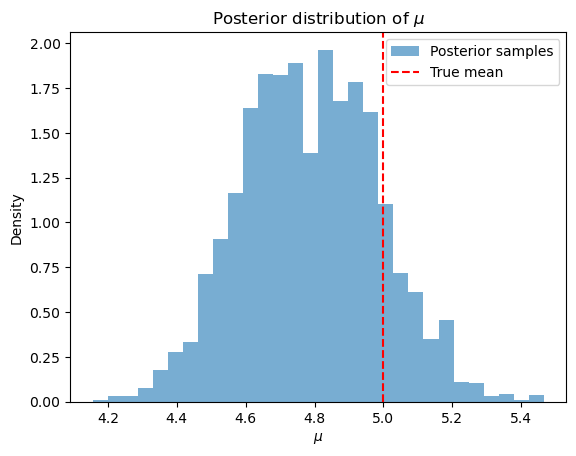

In [10]:
# Plotting the posterior distribution
plt.hist(chain_burned_in, bins=30, density=True, label='Posterior samples', alpha=0.6)
plt.axvline(true_mu, color='red', linestyle='--', label='True mean')
plt.title('Posterior distribution of $\\mu$')
plt.xlabel('$\\mu$')
plt.ylabel('Density')
plt.legend()
plt.show()

Another example : https://exowanderer.medium.com/metropolis-hastings-mcmc-from-scratch-in-python-c21e53c485b7

The below example assumes the true distribution of the data is N(0,1),and the prior is similar. The earlier one makes more sense though.

In [11]:
def mcmc_updater(curr_state, curr_likeli, 
      likelihood, proposal_distribution):
    """ Propose a new state and compare the likelihoods
    
    Given the current state (initially random), 
      current likelihood, the likelihood function, and 
      the transition (proposal) distribution, `mcmc_updater` generates 
      a new proposal, evaluate its likelihood, compares that to the current 
      likelihood with a uniformly samples threshold, 
    then it returns new or current state in the MCMC chain.

    Args:
        curr_state (float): the current parameter/state value
        curr_likeli (float): the current likelihood estimate
        likelihood (function): a function handle to compute the likelihood
        proposal_distribution (function): a function handle to compute the 
          next proposal state

    Returns:
        (tuple): either the current state or the new state
          and its corresponding likelihood
    """
    # Generate a proposal state using the proposal distribution
    # Proposal state == new guess state to be compared to current
    proposal_state = proposal_distribution(curr_state)

    # Calculate the acceptance criterion
    prop_likeli = likelihood(proposal_state)
    accept_crit = prop_likeli / curr_likeli

    # Generate a random number between 0 and 1
    accept_threshold = np.random.uniform(0, 1)

    # If the acceptance criterion is greater than the random number,
    # accept the proposal state as the current state
    if accept_crit > accept_threshold:
        return proposal_state, prop_likeli

    # Else
    return curr_state, curr_likeli

In [12]:
def metropolis_hastings(
        likelihood, proposal_distribution, initial_state, 
        num_samples, stepsize=0.5, burnin=0.2):
    """ Compute the Markov Chain Monte Carlo

    Args:
        likelihood (function): a function handle to compute the likelihood
        proposal_distribution (function): a function handle to compute the 
          next proposal state
        initial_state (list): The initial conditions to start the chain
        num_samples (integer): The number of samples to compte, 
          or length of the chain
        burnin (float): a float value from 0 to 1.
          The percentage of chain considered to be the burnin length

    Returns:
        samples (list): The Markov Chain,
          samples from the posterior distribution
    """
    samples = []

    # The number of samples in the burn in phase
    idx_burnin = int(burnin * num_samples)

    # Set the current state to the initial state
    curr_state = initial_state
    curr_likeli = likelihood(curr_state)

    for i in range(num_samples):
        # The proposal distribution sampling and comparison
        #   occur within the mcmc_updater routine
        curr_state, curr_likeli = mcmc_updater(
            curr_state=curr_state,
            curr_likeli=curr_likeli,
            likelihood=likelihood,
            proposal_distribution=proposal_distribution
        )

        # Append the current state to the list of samples
        if i >= idx_burnin:
            # Only append after the burnin to avoid including
            #   parts of the chain that are prior-dominated
            samples.append(curr_state)

    return samples

In [13]:
def likelihood(x):
    # Standard Normal Distribution
    # An underlying assumption of linear regression is that the residuals
    # are Gaussian Normal Distributed; often, Standard Normal distributed
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

In [14]:
def proposal_distribution(x, stepsize=0.5):
    # Select the proposed state (new guess) from a Gaussian distribution
    #  centered at the current state, within a Guassian of width `stepsize`
    return np.random.normal(x, stepsize)

In [15]:
np.random.seed(42)

initial_state = 0  # Trivial case, starting at the mode of the likelihood
num_samples = int(1e4)
burnin = 0.2

samples = metropolis_hastings(
    likelihood,
    proposal_distribution,
    initial_state,
    num_samples,
    burnin=burnin
)

In [16]:
len(samples) # makes sense as the burn in is 0.2, so probably discarding the initial 20% of the chain

8000

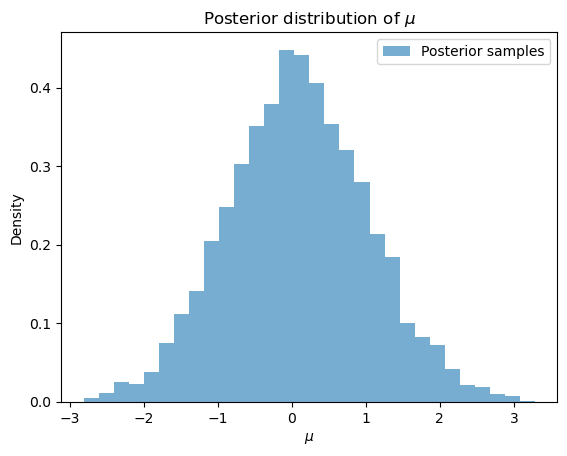

In [17]:
# Plotting the posterior distribution
plt.hist(samples, bins=30, density=True, label='Posterior samples', alpha=0.6)
# plt.axvline(true_mu, color='red', linestyle='--', label='True mean')
plt.title('Posterior distribution of $\\mu$')
plt.xlabel('$\\mu$')
plt.ylabel('Density')
plt.legend()
plt.show()